In [16]:
pip install geopandas shapely contextily scipy

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import contextily as cx
from PIL import Image, ImageEnhance
from tqdm import tqdm
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pyproj import CRS

class Urban3DPrecisionFinal:
    def __init__(self):
        self.home_dir = os.path.expanduser("~")
        self.base_path = os.path.join(self.home_dir, "Desktop/Infor 301/final")
        self.input_dir = os.path.join(self.base_path, "Raw_POI_Archive_2025")
        self.output_dir = os.path.join(self.base_path, "Final_Visuals_Aligned")

        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)

        self.metrics = [
            "bank", "jewelry_store", "art_gallery", "museum", "department_store",
            "shopping_mall", "university", "hospital", "supermarket", "restaurant",
            "subway_station", "park"
        ]

        self.crs_wgs84 = CRS.from_epsg(4326)
        self.crs_webm = CRS.from_epsg(3857)

        self.res = 800          # higher res reduces coastline pixel snapping artifacts
        self.sigma = 5.0        # scaled for res=800

    def entropy_weight(self, df):
        x = df[self.metrics].values + 1e-9
        x_norm = (x - x.min(axis=0)) / (x.max(axis=0) - x.min(axis=0) + 1e-9)
        p = x_norm / (x_norm.sum(axis=0) + 1e-9)
        e = -1 / np.log(len(df)) * np.nansum(p * np.log(p + 1e-9), axis=0)
        w = (1 - e) / (np.sum(1 - e) + 1e-9)
        return dict(zip(self.metrics, w))

    def _coerce_numeric(self, s):
        return pd.to_numeric(s, errors="coerce")

    def _infer_and_build_gdf_3857(self, df):
        if "longitude" not in df.columns or "latitude" not in df.columns:
            raise ValueError("Missing longitude/latitude columns")

        lon = self._coerce_numeric(df["longitude"])
        lat = self._coerce_numeric(df["latitude"])

        m = lon.notna() & lat.notna()
        df = df.loc[m].copy()
        lon = lon.loc[m].to_numpy(dtype=float)
        lat = lat.loc[m].to_numpy(dtype=float)

        if len(lon) == 0:
            raise ValueError("No valid coordinates after numeric coercion")

        lon_abs_max = float(np.nanmax(np.abs(lon)))
        lat_abs_max = float(np.nanmax(np.abs(lat)))

        looks_like_degrees = (lon_abs_max <= 180.5) and (lat_abs_max <= 90.5)

        if not looks_like_degrees:
            lon2, lat2 = lat, lon
            lon2_abs_max = float(np.nanmax(np.abs(lon2)))
            lat2_abs_max = float(np.nanmax(np.abs(lat2)))
            if (lon2_abs_max <= 180.5) and (lat2_abs_max <= 90.5):
                lon, lat = lon2, lat2
                looks_like_degrees = True

        if looks_like_degrees:
            gdf = gpd.GeoDataFrame(
                df,
                geometry=gpd.points_from_xy(lon, lat),
                crs=self.crs_wgs84
            ).to_crs(self.crs_webm)
            return gdf

        gdf = gpd.GeoDataFrame(
            df,
            geometry=gpd.points_from_xy(lon, lat),
            crs=self.crs_webm
        )
        return gdf

    def process_city(self, file_name):
        city_name = file_name.replace("_RAW_2025.csv", "")
        file_path = os.path.join(self.input_dir, file_name)
        if not os.path.exists(file_path):
            return

        df = pd.read_csv(file_path)

        for c in self.metrics:
            if c not in df.columns:
                df[c] = 0.0

        weights = self.entropy_weight(df)
        df["Potential"] = sum(df[m] * weights[m] for m in self.metrics)

        try:
            gdf = self._infer_and_build_gdf_3857(df)
        except Exception as e:
            print(f"[{city_name}] Coord Error: {e}")
            return

        if len(gdf) == 0:
            return

        xmin, ymin, xmax, ymax = gdf.total_bounds
        pad_x, pad_y = (xmax - xmin) * 0.05, (ymax - ymin) * 0.05
        bounds = [xmin - pad_x, ymin - pad_y, xmax + pad_x, ymax + pad_y]

        res = self.res

        try:
            img, extent = cx.bounds2img(
                bounds[0], bounds[1], bounds[2], bounds[3],
                ll=False,
                source=cx.providers.CartoDB.DarkMatter
            )

            pil_img = Image.fromarray(img)
            pil_img = ImageEnhance.Brightness(pil_img).enhance(3.5)
            pil_img = ImageEnhance.Contrast(pil_img).enhance(1.4)

            x0, x1, y0, y1 = extent[0], extent[1], extent[2], extent[3]

            x_vec = np.linspace(x0, x1, res)
            y_vec = np.linspace(y0, y1, res)
            X, Y = np.meshgrid(x_vec, y_vec)

            grid_z = np.zeros((res, res), dtype=float)

            dx = (x1 - x0)
            dy = (y1 - y0)

            xs = gdf.geometry.x.to_numpy()
            ys = gdf.geometry.y.to_numpy()
            ps = pd.to_numeric(gdf["Potential"], errors="coerce").fillna(0).to_numpy()

            # --- bilinear splatting (removes 0~1 pixel snapping bias) ---
            fx = (xs - x0) / dx * (res - 1)
            fy = (ys - y0) / dy * (res - 1)

            ix0 = np.floor(fx).astype(int)
            iy0 = np.floor(fy).astype(int)

            tx = fx - ix0
            ty = fy - iy0

            valid = (ix0 >= 0) & (ix0 < res - 1) & (iy0 >= 0) & (iy0 < res - 1)
            ix0 = ix0[valid]
            iy0 = iy0[valid]
            tx = tx[valid]
            ty = ty[valid]
            pv = ps[valid]

            w00 = (1 - tx) * (1 - ty)
            w10 = tx * (1 - ty)
            w01 = (1 - tx) * ty
            w11 = tx * ty

            np.add.at(grid_z, (iy0,     ix0),     pv * w00)
            np.add.at(grid_z, (iy0,     ix0 + 1), pv * w10)
            np.add.at(grid_z, (iy0 + 1, ix0),     pv * w01)
            np.add.at(grid_z, (iy0 + 1, ix0 + 1), pv * w11)

            landscape = gaussian_filter(grid_z, sigma=self.sigma)

            img_resized = pil_img.convert("RGB").resize((res, res))
            img_array = np.asarray(img_resized) / 255.0

            # If you see vertical inversion in 3D, change to: img_texture_3d = img_array
            img_texture_3d = np.flipud(img_array)

            enhanced_2d_bg = np.asarray(pil_img)

        except Exception as e:
            print(f"[{city_name}] Map Error: {e}")

            x0, x1, y0, y1 = bounds[0], bounds[2], bounds[1], bounds[3]
            extent = (x0, x1, y0, y1)

            x_vec = np.linspace(x0, x1, res)
            y_vec = np.linspace(y0, y1, res)
            X, Y = np.meshgrid(x_vec, y_vec)

            grid_z = np.zeros((res, res), dtype=float)

            dx = (x1 - x0)
            dy = (y1 - y0)

            xs = gdf.geometry.x.to_numpy()
            ys = gdf.geometry.y.to_numpy()
            ps = pd.to_numeric(gdf["Potential"], errors="coerce").fillna(0).to_numpy()

            fx = (xs - x0) / dx * (res - 1)
            fy = (ys - y0) / dy * (res - 1)

            ix0 = np.floor(fx).astype(int)
            iy0 = np.floor(fy).astype(int)

            tx = fx - ix0
            ty = fy - iy0

            valid = (ix0 >= 0) & (ix0 < res - 1) & (iy0 >= 0) & (iy0 < res - 1)
            ix0 = ix0[valid]
            iy0 = iy0[valid]
            tx = tx[valid]
            ty = ty[valid]
            pv = ps[valid]

            w00 = (1 - tx) * (1 - ty)
            w10 = tx * (1 - ty)
            w01 = (1 - tx) * ty
            w11 = tx * ty

            np.add.at(grid_z, (iy0,     ix0),     pv * w00)
            np.add.at(grid_z, (iy0,     ix0 + 1), pv * w10)
            np.add.at(grid_z, (iy0 + 1, ix0),     pv * w01)
            np.add.at(grid_z, (iy0 + 1, ix0 + 1), pv * w11)

            landscape = gaussian_filter(grid_z, sigma=self.sigma)

            img_texture_3d = np.zeros((res, res, 3))
            enhanced_2d_bg = None

        # --- 3D RENDERING ---
        fig_3d = plt.figure(figsize=(16, 12), facecolor="black")
        ax_3d = fig_3d.add_subplot(111, projection="3d", facecolor="black")

        ax_3d.plot_surface(
            X, Y, np.zeros_like(landscape),
            rstride=1, cstride=1,
            facecolors=img_texture_3d,
            shade=False, antialiased=True, lw=0
        )

        surf = ax_3d.plot_surface(
            X, Y, landscape,
            cmap="magma",
            edgecolor="none",
            alpha=0.8,
            antialiased=True,
            rcount=res,
            ccount=res
        )

        cbar = fig_3d.colorbar(surf, ax=ax_3d, shrink=0.4, aspect=15, pad=0.02)
        cbar.ax.yaxis.set_tick_params(color="white", labelcolor="white")

        ax_3d.view_init(elev=45, azim=155)
        ax_3d.set_axis_off()
        ax_3d.set_zlim(0, float(np.max(landscape)) * 2.0 if np.max(landscape) > 0 else 1.0)

        plt.savefig(
            os.path.join(self.output_dir, f"{city_name}_3D_Precision.png"),
            dpi=300, facecolor="black",
            bbox_inches="tight", pad_inches=0
        )
        plt.close()

        # --- 2D RENDERING ---
        fig_2d, ax_2d = plt.subplots(figsize=(12, 12), facecolor="black")

        if enhanced_2d_bg is not None:
            ax_2d.imshow(enhanced_2d_bg, extent=[extent[0], extent[1], extent[2], extent[3]])

        sc = ax_2d.scatter(
            gdf.geometry.x,
            gdf.geometry.y,
            c=pd.to_numeric(gdf["Potential"], errors="coerce").fillna(0),
            cmap="magma",
            s=40, alpha=0.8,
            edgecolors="none"
        )

        divider = make_axes_locatable(ax_2d)
        cax = divider.append_axes("right", size="2%", pad=0.05)
        cbar_2d = fig_2d.colorbar(sc, cax=cax)
        cbar_2d.ax.yaxis.set_tick_params(color="white", labelcolor="white")

        ax_2d.set_axis_off()

        plt.savefig(
            os.path.join(self.output_dir, f"{city_name}_2D_Precision.png"),
            dpi=300, facecolor="black",
            bbox_inches="tight", pad_inches=0
        )
        plt.close()

    def run(self):
        files = [f for f in os.listdir(self.input_dir) if f.endswith(".csv")]
        for f in tqdm(files):
            self.process_city(f)

if __name__ == "__main__":
    viz = Urban3DPrecisionFinal()
    viz.run()

In [8]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import contextily as cx
from PIL import Image, ImageEnhance
from tqdm import tqdm
import geopandas as gpd
from pyproj import CRS

class Urban3DPrecisionFinal:
    def __init__(self):
        self.home_dir = os.path.expanduser("~")
        self.base_path = os.path.join(self.home_dir, "Desktop/Infor 301/final")
        self.input_dir = os.path.join(self.base_path, "Raw_POI_Archive_2025")
        self.output_dir = os.path.join(self.base_path, "Final_Visuals_Aligned")

        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)

        self.metrics = [
            "bank", "jewelry_store", "art_gallery", "museum", "department_store",
            "shopping_mall", "university", "hospital", "supermarket", "restaurant",
            "subway_station", "park"
        ]

        self.us_cities = ["Chicago", "Houston", "Los Angeles", "New York", "San Francisco"]
        self.uk_cities = ["Glasgow City", "Greater London", "Greater Manchester", "West Midlands", "West Yorkshire"]

        self.crs_wgs84 = CRS.from_epsg(4326)
        self.crs_webm = CRS.from_epsg(3857)
        
        # 保持 1000 的高分辨率网格
        self.res = 1000 
        self.sigma = 4.5

    def entropy_weight(self, df):
        x = df[self.metrics].values + 1e-9
        x_norm = (x - x.min(axis=0)) / (x.max(axis=0) - x.min(axis=0) + 1e-9)
        p = x_norm / (x_norm.sum(axis=0) + 1e-9)
        e = -1 / np.log(len(df)) * np.nansum(p * np.log(p + 1e-9), axis=0)
        w = (1 - e) / (np.sum(1 - e) + 1e-9)
        return dict(zip(self.metrics, w))

    def _infer_and_build_gdf_3857(self, df):
        lon = pd.to_numeric(df["longitude"], errors="coerce")
        lat = pd.to_numeric(df["latitude"], errors="coerce")
        m = lon.notna() & lat.notna()
        gdf = gpd.GeoDataFrame(df.loc[m], geometry=gpd.points_from_xy(lon.loc[m], lat.loc[m]), crs=self.crs_wgs84)
        return gdf.to_crs(self.crs_webm)

    def get_city_data(self, city_name):
        file_path = os.path.join(self.input_dir, f"{city_name}_RAW_2025.csv")
        if not os.path.exists(file_path):
            alt_path = os.path.join(self.input_dir, f"{city_name.replace(' ', '')}_RAW_2025.csv")
            file_path = alt_path if os.path.exists(alt_path) else None

        if not file_path: return None

        df = pd.read_csv(file_path)
        for c in self.metrics:
            if c not in df.columns: df[c] = 0.0

        weights = self.entropy_weight(df)
        df["Potential"] = sum(df[m] * weights[m] for m in self.metrics)
        gdf = self._infer_and_build_gdf_3857(df)

        xmin, ymin, xmax, ymax = gdf.total_bounds
        pad_x, pad_y = (xmax - xmin) * 0.1, (ymax - ymin) * 0.1
        bounds = [xmin - pad_x, ymin - pad_y, xmax + pad_x, ymax + pad_y]

        # --- 修正后的 Zoom 获取逻辑 ---
        # 使用 howmany 获取适合当前边界的自动 zoom 级别，避免直接调用内部私有方法
        try:
            zoom = cx.howmany(bounds[0], bounds[1], bounds[2], bounds[3], 1, ll=False)[1]
        except:
            zoom = "auto" # 如果版本极老，退回到 auto

        img, extent = cx.bounds2img(bounds[0], bounds[1], bounds[2], bounds[3], 
                                    zoom=zoom, ll=False, 
                                    source=cx.providers.CartoDB.DarkMatter)
        
        pil_img = Image.fromarray(img)
        # 提亮与增强对比度
        pil_img = ImageEnhance.Brightness(pil_img).enhance(5.5)
        pil_img = ImageEnhance.Contrast(pil_img).enhance(1.3)
        
        x_vec = np.linspace(extent[0], extent[1], self.res)
        y_vec = np.linspace(extent[2], extent[3], self.res)
        X, Y = np.meshgrid(x_vec, y_vec)
        grid_z = np.zeros((self.res, self.res))

        xs, ys = gdf.geometry.x.values, gdf.geometry.y.values
        ps = pd.to_numeric(gdf["Potential"]).fillna(0).values
        fx = (xs - extent[0]) / (extent[1] - extent[0]) * (self.res - 1)
        fy = (ys - extent[2]) / (extent[3] - extent[2]) * (self.res - 1)
        mask = (fx >= 0) & (fx < self.res-1) & (fy >= 0) & (fy < self.res-1)
        np.add.at(grid_z, (fy[mask].astype(int), fx[mask].astype(int)), ps[mask])
        landscape = gaussian_filter(grid_z, sigma=self.sigma)
        
        return {"name": city_name, "gdf": gdf, "X": X, "Y": Y, "landscape": landscape, "extent": extent, "img": pil_img}

    def generate_combined_plots(self):
        cities_to_plot = self.us_cities + self.uk_cities
        all_data = [d for d in [self.get_city_data(name) for name in cities_to_plot] if d]

        # --- 2D 合并图 ---
        fig_2d, axes_2d = plt.subplots(2, 5, figsize=(26, 11), facecolor="black")
        sc = None
        for i, data in enumerate(all_data):
            ax = axes_2d[divmod(i, 5)]
            ax.imshow(data["img"], extent=data["extent"], interpolation='lanczos')
            sc = ax.scatter(data["gdf"].geometry.x, data["gdf"].geometry.y, c=data["gdf"]["Potential"], cmap="magma", s=3, alpha=0.6)
            ax.set_title(data["name"], color="white", fontsize=18, pad=12)
            ax.set_axis_off()
        
        cbar_ax_2d = fig_2d.add_axes([0.94, 0.15, 0.015, 0.7])
        cbar_2d = fig_2d.colorbar(sc, cax=cbar_ax_2d)
        cbar_2d.ax.yaxis.set_tick_params(color="white", labelcolor="white")
        fig_2d.savefig(os.path.join(self.output_dir, "Grid_2D_Final.png"), dpi=300, facecolor="black", bbox_inches="tight")

        # --- 3D 合并图 ---
        fig_3d = plt.figure(figsize=(30, 13), facecolor="black")
        surf = None
        for i, data in enumerate(all_data):
            ax3 = fig_3d.add_subplot(2, 5, i+1, projection="3d", facecolor="black")
            
            # 使用高品质重采样确保清晰
            img_resized = np.flipud(np.asarray(data["img"].convert("RGB").resize((self.res, self.res), Image.Resampling.LANCZOS)) / 255.0)
            
            # 底层地平面：增加 rcount/ccount 采样率
            ax3.plot_surface(data["X"], data["Y"], np.zeros_like(data["landscape"]), 
                             facecolors=img_resized, shade=False, antialiased=True, lw=0, rcount=self.res, ccount=self.res)
            
            # 潜力起伏：略微降低 rcount 提升渲染速度，但不影响底图清晰度
            surf = ax3.plot_surface(data["X"], data["Y"], data["landscape"], cmap="magma", alpha=0.7, rcount=150, ccount=150, lw=0, antialiased=True)
            
            ax3.set_title(data["name"], color="white", fontsize=18, y=1.02)
            ax3.view_init(elev=32, azim=150)
            ax3.set_axis_off()
            
            z_max = np.max(data["landscape"])
            ax3.set_zlim(0, z_max * 1.8 if z_max > 0 else 1)

        cbar_ax_3d = fig_3d.add_axes([0.93, 0.15, 0.012, 0.7])
        cbar_3d = fig_3d.colorbar(surf, cax=cbar_ax_3d)
        cbar_3d.set_label('Urban Potential Intensity', color='white', labelpad=10)
        cbar_3d.ax.yaxis.set_tick_params(color="white", labelcolor="white")
        
        plt.subplots_adjust(left=0.01, right=0.92, bottom=0.05, top=0.95, wspace=0.05, hspace=0.1)
        fig_3d.savefig(os.path.join(self.output_dir, "Grid_3D_Final.png"), dpi=400, facecolor="black")
        
        plt.close('all')
        print(f"Done! Files saved in: {self.output_dir}")

if __name__ == "__main__":
    Urban3DPrecisionFinal().generate_combined_plots()

Using zoom level 1, this will download 1 tiles
Using zoom level 1, this will download 1 tiles
Using zoom level 1, this will download 1 tiles
Using zoom level 1, this will download 1 tiles
Using zoom level 1, this will download 1 tiles
Using zoom level 1, this will download 1 tiles
Using zoom level 1, this will download 2 tiles
Using zoom level 1, this will download 1 tiles
Using zoom level 1, this will download 1 tiles
Using zoom level 1, this will download 1 tiles
Done! Files saved in: /Users/oushilin/Desktop/Infor 301/final/Final_Visuals_Aligned


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import contextily as cx
from PIL import Image, ImageEnhance
from tqdm import tqdm
import geopandas as gpd
from pyproj import CRS

class Urban3DPrecisionFinal:
    def __init__(self):
        self.home_dir = os.path.expanduser("~")
        # 请确保路径与您的实际环境一致
        self.base_path = os.path.join(self.home_dir, "Desktop/Infor 301/final")
        self.input_dir = os.path.join(self.base_path, "Raw_POI_Archive_2025")
        self.output_dir = os.path.join(self.base_path, "Final_Visuals_Aligned")

        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)

        self.metrics = [
            "bank", "jewelry_store", "art_gallery", "museum", "department_store",
            "shopping_mall", "university", "hospital", "supermarket", "restaurant",
            "subway_station", "park"
        ]

        self.us_cities = ["Chicago", "Houston", "Los Angeles", "New York", "San Francisco"]
        self.uk_cities = ["Glasgow City", "Greater London", "Greater Manchester", "West Midlands", "West Yorkshire"]

        self.crs_wgs84 = CRS.from_epsg(4326)
        self.crs_webm = CRS.from_epsg(3857)
        
        # Grid resolution and smoothing
        self.res = 1000 
        self.sigma = 4.5

    def entropy_weight(self, df):
        x = df[self.metrics].values + 1e-9
        x_norm = (x - x.min(axis=0)) / (x.max(axis=0) - x.min(axis=0) + 1e-9)
        p = x_norm / (x_norm.sum(axis=0) + 1e-9)
        e = -1 / np.log(len(df)) * np.nansum(p * np.log(p + 1e-9), axis=0)
        w = (1 - e) / (np.sum(1 - e) + 1e-9)
        return dict(zip(self.metrics, w))

    def _infer_and_build_gdf_3857(self, df):
        lon = pd.to_numeric(df["longitude"], errors="coerce")
        lat = pd.to_numeric(df["latitude"], errors="coerce")
        m = lon.notna() & lat.notna()
        gdf = gpd.GeoDataFrame(df.loc[m], geometry=gpd.points_from_xy(lon.loc[m], lat.loc[m]), crs=self.crs_wgs84)
        return gdf.to_crs(self.crs_webm)

    def get_city_data(self, city_name):
        file_path = os.path.join(self.input_dir, f"{city_name}_RAW_2025.csv")
        if not os.path.exists(file_path):
            alt_path = os.path.join(self.input_dir, f"{city_name.replace(' ', '')}_RAW_2025.csv")
            file_path = alt_path if os.path.exists(alt_path) else None

        if not file_path: return None

        df = pd.read_csv(file_path)
        for c in self.metrics:
            if c not in df.columns: df[c] = 0.0

        weights = self.entropy_weight(df)
        df["Potential"] = sum(df[m] * weights[m] for m in self.metrics)
        gdf = self._infer_and_build_gdf_3857(df)

        xmin, ymin, xmax, ymax = gdf.total_bounds
        pad_x, pad_y = (xmax - xmin) * 0.1, (ymax - ymin) * 0.1
        bounds = [xmin - pad_x, ymin - pad_y, xmax + pad_x, ymax + pad_y]

        try:
            zoom = cx.howmany(bounds[0], bounds[1], bounds[2], bounds[3], 1, ll=False)[1]
        except:
            zoom = "auto"

        img, extent = cx.bounds2img(bounds[0], bounds[1], bounds[2], bounds[3], 
                                    zoom=zoom, ll=False, 
                                    source=cx.providers.CartoDB.DarkMatter)
        
        pil_img = Image.fromarray(img).convert("RGB")
        
        # --- 图像增强优化 (高亮且高清晰版) ---
        # 1. 强力锐化：大幅增强边缘，对抗亮度提升带来的模糊
        pil_img = ImageEnhance.Sharpness(pil_img).enhance(3.0) 
        # 2. 高亮度：大幅提升，从之前的 4.0 提升到 6.5
        pil_img = ImageEnhance.Brightness(pil_img).enhance(6.5)
        # 3. 高对比度：必须配合高对比度 (2.2)，将背景压黑，突出白色街道
        pil_img = ImageEnhance.Contrast(pil_img).enhance(2.2)
        # 4. 色彩微调：保持色彩饱和度
        pil_img = ImageEnhance.Color(pil_img).enhance(1.3)
        
        x_vec = np.linspace(extent[0], extent[1], self.res)
        y_vec = np.linspace(extent[2], extent[3], self.res)
        X, Y = np.meshgrid(x_vec, y_vec)
        grid_z = np.zeros((self.res, self.res))

        xs, ys = gdf.geometry.x.values, gdf.geometry.y.values
        ps = pd.to_numeric(gdf["Potential"]).fillna(0).values
        fx = (xs - extent[0]) / (extent[1] - extent[0]) * (self.res - 1)
        fy = (ys - extent[2]) / (extent[3] - extent[2]) * (self.res - 1)
        mask = (fx >= 0) & (fx < self.res-1) & (fy >= 0) & (fy < self.res-1)
        np.add.at(grid_z, (fy[mask].astype(int), fx[mask].astype(int)), ps[mask])
        landscape = gaussian_filter(grid_z, sigma=self.sigma)
        
        return {"name": city_name, "gdf": gdf, "X": X, "Y": Y, "landscape": landscape, "extent": extent, "img": pil_img}

    def generate_combined_plots(self):
        cities_to_plot = self.us_cities + self.uk_cities
        all_data = [d for d in [self.get_city_data(name) for name in cities_to_plot] if d]

        if not all_data:
            print("No data found to plot.")
            return

        # --- 2D Plot ---
        fig_2d, axes_2d = plt.subplots(2, 5, figsize=(26, 11), facecolor="black")
        sc = None
        for i, data in enumerate(all_data):
            ax = axes_2d[divmod(i, 5)]
            ax.imshow(data["img"], extent=data["extent"], interpolation='lanczos')
            sc = ax.scatter(data["gdf"].geometry.x, data["gdf"].geometry.y, c=data["gdf"]["Potential"], cmap="magma", s=3, alpha=0.6)
            ax.set_title(data["name"], color="white", fontsize=18, pad=12)
            ax.set_axis_off()
        
        cbar_ax_2d = fig_2d.add_axes([0.94, 0.15, 0.015, 0.7])
        cbar_2d = fig_2d.colorbar(sc, cax=cbar_ax_2d)
        cbar_2d.ax.yaxis.set_tick_params(color="white", labelcolor="white")
        fig_2d.savefig(os.path.join(self.output_dir, "Grid_2D_Final.png"), dpi=300, facecolor="black", bbox_inches="tight")

        # --- 3D Plot ---
        fig_3d = plt.figure(figsize=(30, 13), facecolor="black")
        surf = None
        for i, data in enumerate(all_data):
            ax3 = fig_3d.add_subplot(2, 5, i+1, projection="3d", facecolor="black")
            
            # 使用 Lanczos 重采样确保贴图质量
            img_resized = np.flipud(np.asarray(data["img"].resize((self.res, self.res), Image.Resampling.LANCZOS)) / 255.0)
            
            # 保持高分辨率 rcount/ccount = self.res (1000) 以确保清晰度
            # shade=False 确保直接使用贴图颜色，不受光照变暗影响
            ax3.plot_surface(data["X"], data["Y"], np.zeros_like(data["landscape"]), 
                             facecolors=img_resized, shade=False, antialiased=True, 
                             lw=0, rcount=self.res, ccount=self.res, zorder=1)
            
            # 潜力起伏层
            surf = ax3.plot_surface(data["X"], data["Y"], data["landscape"], 
                                    cmap="magma", alpha=0.6, rcount=200, ccount=200, 
                                    lw=0, antialiased=True, zorder=2)
            
            ax3.set_title(data["name"], color="white", fontsize=18, y=1.02)
            ax3.view_init(elev=32, azim=150)
            ax3.set_axis_off()
            
            z_max = np.max(data["landscape"])
            ax3.set_zlim(0, z_max * 2.0 if z_max > 0 else 1)

        cbar_ax_3d = fig_3d.add_axes([0.93, 0.15, 0.012, 0.7])
        cbar_3d = fig_3d.colorbar(surf, cax=cbar_ax_3d)
        cbar_3d.set_label('Urban Potential Intensity', color='white', labelpad=10)
        cbar_3d.ax.yaxis.set_tick_params(color="white", labelcolor="white")
        
        plt.subplots_adjust(left=0.01, right=0.92, bottom=0.05, top=0.95, wspace=0.05, hspace=0.1)
        fig_3d.savefig(os.path.join(self.output_dir, "Grid_3D_Final.png"), dpi=400, facecolor="black")
        
        plt.close('all')
        print(f"Done! Files saved in: {self.output_dir}")

if __name__ == "__main__":
    Urban3DPrecisionFinal().generate_combined_plots()

Using zoom level 1, this will download 1 tiles
Using zoom level 1, this will download 1 tiles
Using zoom level 1, this will download 1 tiles
Using zoom level 1, this will download 1 tiles
Using zoom level 1, this will download 1 tiles
Using zoom level 1, this will download 1 tiles
Using zoom level 1, this will download 2 tiles
Using zoom level 1, this will download 1 tiles
Using zoom level 1, this will download 1 tiles
Using zoom level 1, this will download 1 tiles
Done! Files saved in: /Users/oushilin/Desktop/Infor 301/final/Final_Visuals_Aligned


--- 🚀 Device: mps ---
--- 🌍 Generating Composite Figure... ---
--- 📊 Data Check: 42990 rows collected. ---
      City  Year  Displacement
0  Chicago  2016           0.0
1  Chicago  2016           0.0
2  Chicago  2016           0.0
3  Chicago  2016           0.0
4  Chicago  2016           0.0
--- Fitting UMAP for Panel A... ---
--- Rendering Panel A... ---
--- Rendering Panel B... ---


/Users/oushilin/anaconda3/envs/urban_research/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/var/folders/jt/s5bg7p6n4mgfx_dznzr9hr7c0000gn/T/ipykernel_11726/411179533.py:259: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


--- ✅ SOTA Composite Figure Saved: /Users/oushilin/Desktop/Infor 301/final/Figure_1_SOTA_Fixed.png ---


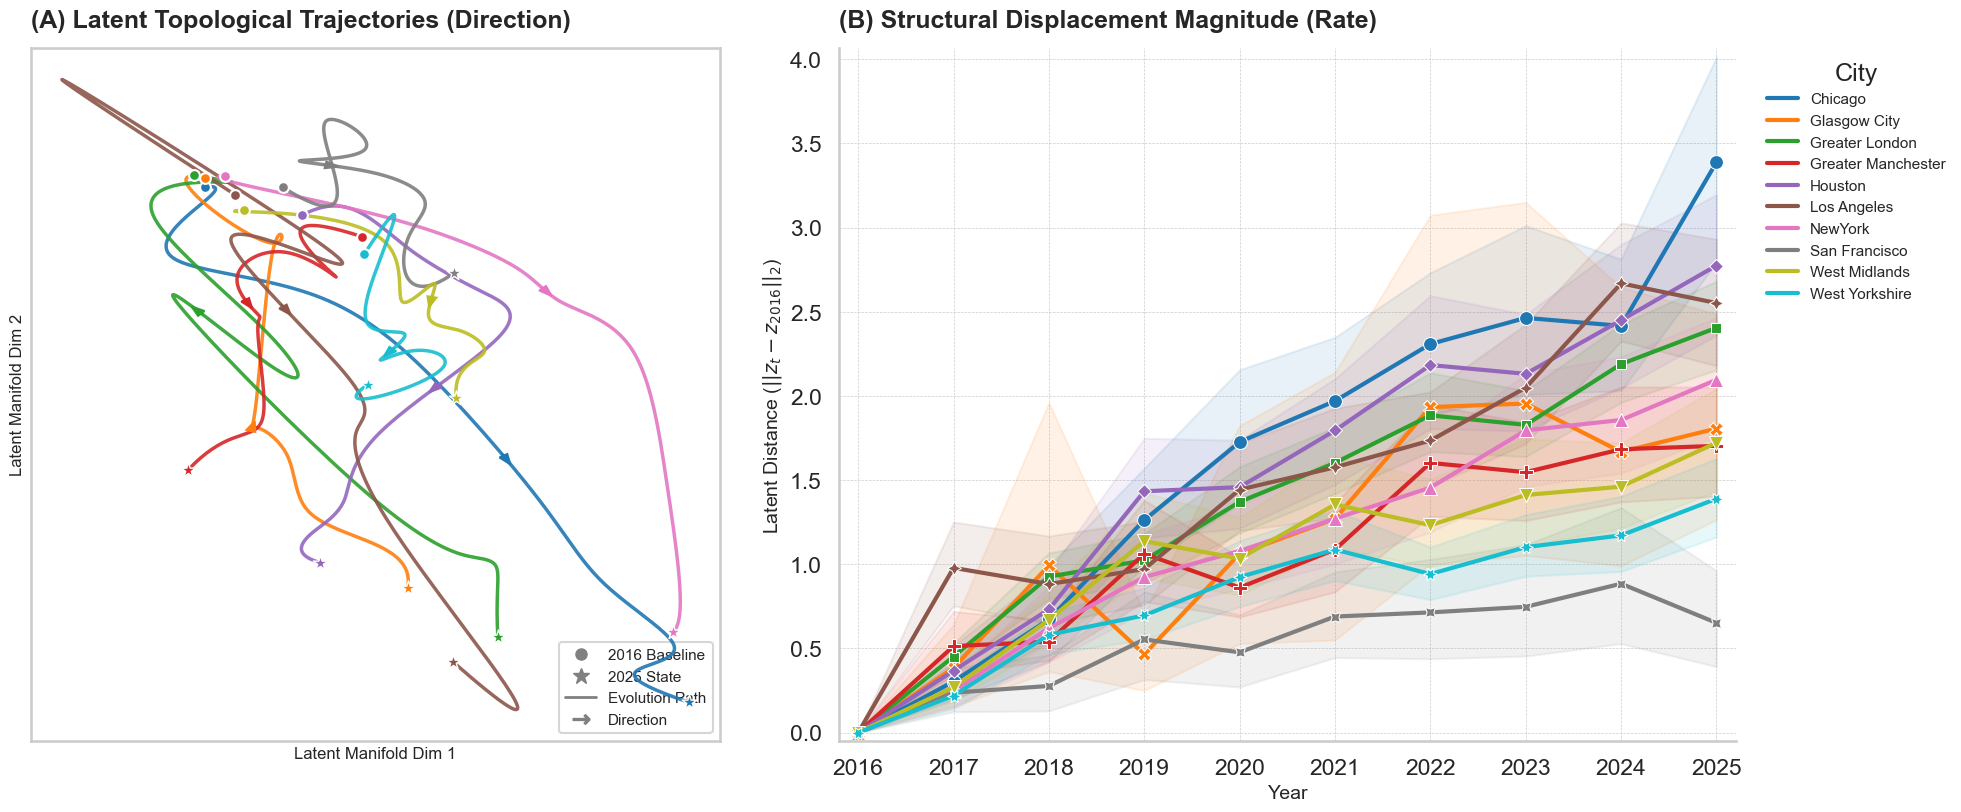

In [14]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import umap
from scipy.interpolate import make_interp_spline
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D  # 全局导入，防止作用域错误
from matplotlib.ticker import MaxNLocator

# ==========================================
# 1. Model Definition (Fixed Architecture)
# ==========================================
class DeepUrbanTransformer(nn.Module):
    def __init__(self, node_features, periods, d_model=128, nhead=16, num_layers=6, latent_dim=64):
        super(DeepUrbanTransformer, self).__init__()
        self.embedding = nn.Sequential(
            nn.Linear(node_features, d_model), nn.GELU(), nn.LayerNorm(d_model), nn.Dropout(0.1)
        )
        self.pos_encoder = nn.Parameter(torch.randn(1, periods, d_model))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=512,
            dropout=0.1, batch_first=True, norm_first=True 
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_mu = nn.Linear(d_model, latent_dim)
        self.fc_logvar = nn.Linear(d_model, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256), nn.GELU(),
            nn.Linear(256, node_features * periods) 
        )

    def encode(self, x):
        x = x.permute(0, 2, 1) 
        h = self.embedding(x) + self.pos_encoder
        h = self.transformer(h)
        h_avg = torch.mean(h, dim=1)
        return self.fc_mu(h_avg)

# ==========================================
# 2. SOTA Figure Generator (Fixed)
# ==========================================
class SOTAUrbanFigure:
    def __init__(self, dataset_path, weights_path):
        self.device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
        print(f"--- 🚀 Device: {self.device} ---")
        
        self.dataset_path = os.path.expanduser(dataset_path)
        self.weights_path = os.path.expanduser(weights_path)
        self.full_data = torch.load(self.dataset_path)
        self.model = self._load_model()
        
        self.city_names = sorted(list(self.full_data.keys()))
        self.colors = sns.color_palette("tab10", len(self.city_names))
        self.color_map = {city: col for city, col in zip(self.city_names, self.colors)}

    def _load_model(self):
        model = DeepUrbanTransformer(
            node_features=7, periods=10, d_model=128, nhead=16, num_layers=6
        ).to(self.device)
        if os.path.exists(self.weights_path):
            state_dict = torch.load(self.weights_path, map_location=self.device)
            if list(state_dict.keys())[0].startswith('module.'):
                state_dict = {k[7:]: v for k, v in state_dict.items()}
            model.load_state_dict(state_dict)
            model.eval()
        return model

    def get_city_data(self, city_name):
        raw_tensor = self.full_data[city_name]["features"] 
        features = raw_tensor.permute(1, 2, 0) 
        mean = features.mean(dim=(0, 2), keepdim=True)
        std = features.std(dim=(0, 2), keepdim=True) + 1e-6
        norm_features = (features - mean) / std
        
        # 1. Baseline (2016)
        feat_2016 = norm_features[:, :, 0:1].repeat(1, 1, 10).to(self.device)
        with torch.no_grad():
            z_2016 = self.model.encode(feat_2016).cpu().numpy()

        centroids = []
        displacement_records = []

        # 2. Iterate Years
        for t in range(10):
            year = 2016 + t
            feat_t = norm_features[:, :, t:t+1].repeat(1, 1, 10).to(self.device)
            with torch.no_grad():
                z_t = self.model.encode(feat_t).cpu().numpy()
            
            # Panel A: Centroid
            # Handle NaNs just in case
            z_t = np.nan_to_num(z_t)
            centroids.append(np.mean(z_t, axis=0))
            
            # Panel B: Distance from 2016
            # Ensure z_2016 is also clean
            z_2016 = np.nan_to_num(z_2016)
            dists = np.linalg.norm(z_t - z_2016, axis=1)
            
            # Force float32 -> float (Python native) to avoid Seaborn errors
            dists = dists.astype(float)
            
            # Subsample 25%
            if len(dists) > 0:
                idx = np.random.choice(len(dists), size=int(len(dists)*0.25), replace=False)
                sampled_dists = dists[idx]
                
                for d in sampled_dists:
                    displacement_records.append({
                        "City": city_name,
                        "Year": int(year),
                        "Displacement": d
                    })
            
        return np.array(centroids), displacement_records

    def generate_sota_plot(self, amp_factor=6.0):
        print("--- 🌍 Generating Composite Figure... ---")
        
        all_centroids = []
        meta_centroids = []
        all_divergence = []
        
        for city in self.city_names:
            cents, disps = self.get_city_data(city)
            all_centroids.append(cents)
            for t in range(10):
                meta_centroids.append((city, t))
            all_divergence.extend(disps)
            
        X_centroids = np.vstack(all_centroids)
        
        # --- CRITICAL FIX: Ensure DataFrame is clean ---
        df_div = pd.DataFrame(all_divergence)
        print(f"--- 📊 Data Check: {len(df_div)} rows collected. ---")
        print(df_div.head()) # Debug: Show first few rows
        
        # Drop NaNs
        df_div = df_div.dropna()
        if len(df_div) == 0:
            print("❌ ERROR: DataFrame is empty after dropping NaNs. Check model outputs.")
            return

        # UMAP for Panel A
        print("--- Fitting UMAP for Panel A... ---")
        reducer = umap.UMAP(n_neighbors=50, min_dist=0.2, metric='cosine', random_state=42)
        emb_centroids = reducer.fit_transform(X_centroids)
        
        self._plot_composite(emb_centroids, meta_centroids, df_div, amp_factor)

    def _plot_composite(self, emb_c, meta_c, df_div, amp_factor):
        fig = plt.figure(figsize=(22, 9), facecolor='white') 
        gs = GridSpec(1, 2, width_ratios=[1, 1.3], wspace=0.15)
        
        ax1 = fig.add_subplot(gs[0]) # Panel A
        ax2 = fig.add_subplot(gs[1]) # Panel B
        
        # ==========================================
        # Panel A: Trajectory
        # ==========================================
        print("--- Rendering Panel A... ---")
        city_paths = {city: [] for city in self.city_names}
        for i, (city, year) in enumerate(meta_c):
            city_paths[city].append(emb_c[i])
            
        for city in self.city_names:
            path = np.array(city_paths[city])
            color = self.color_map[city]
            
            start_pt = path[0]
            amplified_path = start_pt + (path - start_pt) * amp_factor
            
            # Robust Spline: Ensure no duplicate points causing errors
            t_orig = np.linspace(0, 9, 10)
            t_smooth = np.linspace(0, 9, 200)
            try:
                spl_x = make_interp_spline(t_orig, amplified_path[:, 0], k=3)
                spl_y = make_interp_spline(t_orig, amplified_path[:, 1], k=3)
                x_s, y_s = spl_x(t_smooth), spl_y(t_smooth)
            except:
                # Fallback to linear if spline fails
                x_s, y_s = amplified_path[:, 0], amplified_path[:, 1]
            
            ax1.plot(x_s, y_s, color=color, linewidth=2.5, alpha=0.9, zorder=10)
            ax1.scatter(amplified_path[0, 0], amplified_path[0, 1], color=color, s=60, marker='o', edgecolors='white', lw=1.5, zorder=11)
            ax1.scatter(amplified_path[-1, 0], amplified_path[-1, 1], color=color, s=120, marker='*', edgecolors='white', lw=1.0, zorder=11)
            
            mid_idx = 100 
            if mid_idx < len(x_s) - 5:
                dx = x_s[mid_idx+5] - x_s[mid_idx]
                dy = y_s[mid_idx+5] - y_s[mid_idx]
                ax1.arrow(x_s[mid_idx], y_s[mid_idx], dx*0.05, dy*0.05, color=color, head_width=0.3, alpha=1.0, zorder=12)

        ax1.set_title("(A) Latent Topological Trajectories (Direction)", fontsize=18, weight='bold', loc='left', pad=15)
        ax1.set_xlabel("Latent Manifold Dim 1", fontsize=12)
        ax1.set_ylabel("Latent Manifold Dim 2", fontsize=12)
        ax1.set_xticks([])
        ax1.set_yticks([])
        ax1.grid(True, linestyle=':', alpha=0.3)

        # Legend A
        legend_a = [
            Line2D([0], [0], marker='o', color='gray', label='2016 Baseline', markerfacecolor='gray', markersize=8, linestyle='None'),
            Line2D([0], [0], marker='*', color='gray', label='2025 State', markerfacecolor='gray', markersize=12, linestyle='None'),
            Line2D([0], [0], color='gray', lw=2, label='Evolution Path'),
            Line2D([0], [0], marker=r'$\rightarrow$', color='gray', label='Direction', markersize=12, linestyle='None')
        ]
        ax1.legend(handles=legend_a, loc='lower right', fontsize=11, frameon=True)

        # ==========================================
        # Panel B: Divergence Plot (Fixed)
        # ==========================================
        print("--- Rendering Panel B... ---")
        
        # Check if data exists before plotting
        if df_div.empty:
             print("❌ Skipping Panel B: No data available.")
        else:
            sns.lineplot(
                data=df_div, 
                x="Year", 
                y="Displacement", 
                hue="City",
                palette=self.colors,
                linewidth=3,
                markers=True,
                markersize=10,
                style="City",
                dashes=False,
                errorbar=('ci', 95),
                err_style='band',
                err_kws={'alpha': 0.1},
                ax=ax2,
                legend=False
            )
            
            mean_series = df_div.groupby(['City', 'Year'])['Displacement'].mean()
            if not mean_series.empty:
                max_mean = mean_series.max()
                ax2.set_ylim(-0.05, max_mean * 1.2)
            
            ax2.set_title("(B) Structural Displacement Magnitude (Rate)", fontsize=18, weight='bold', loc='left', pad=15)
            ax2.set_ylabel("Latent Distance ($||z_t - z_{2016}||_2$)", fontsize=14)
            ax2.set_xlabel("Year", fontsize=14)
            ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
            ax2.set_xlim(2015.8, 2025.2)
            ax2.grid(True, linestyle='--', linewidth=0.5)
            sns.despine(ax=ax2)
            
            # Shared Legend
            city_handles = [Line2D([0], [0], color=self.color_map[c], lw=3) for c in self.city_names]
            ax2.legend(city_handles, self.city_names, title="City", 
                       bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False, fontsize=11)

        plt.tight_layout()
        save_path = os.path.expanduser(f"~/Desktop/Infor 301/final/Figure_1_SOTA_Fixed.png")
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"--- ✅ SOTA Composite Figure Saved: {save_path} ---")
        plt.show()

# ==========================================
# Run
# ==========================================
if __name__ == "__main__":
    DATASET_PATH = "~/Desktop/Infor 301/final/Processed_Urban_Dataset.pt"
    WEIGHTS_PATH = "~/Desktop/Infor 301/final/DeepUrbanTransformer_Weights.pth"
    
    try:
        viz = SOTAUrbanFigure(DATASET_PATH, WEIGHTS_PATH)
        viz.generate_sota_plot(amp_factor=6.0)
    except Exception as e:
        print(f"Error: {e}")

In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import contextily as cx
from PIL import Image, ImageEnhance
import geopandas as gpd
from pyproj import CRS

class Urban2DPrecisionFinal:
    def __init__(self):
        self.home_dir = os.path.expanduser("~")
        # Ensure this matches your actual environment path
        self.base_path = os.path.join(self.home_dir, "Desktop/Infor 301/final")
        self.input_dir = os.path.join(self.base_path, "Raw_POI_Archive_2025")
        self.output_dir = os.path.join(self.base_path, "Final_Visuals_Aligned")

        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)

        self.metrics = [
            "bank", "jewelry_store", "art_gallery", "museum", "department_store",
            "shopping_mall", "university", "hospital", "supermarket", "restaurant",
            "subway_station", "park"
        ]

        self.us_cities = ["Chicago", "Houston", "Los Angeles", "New York", "San Francisco"]
        self.uk_cities = ["Glasgow City", "Greater London", "Greater Manchester", "West Midlands", "West Yorkshire"]

        self.crs_wgs84 = CRS.from_epsg(4326)
        self.crs_webm = CRS.from_epsg(3857)

    def entropy_weight(self, df):
        x = df[self.metrics].values + 1e-9
        x_norm = (x - x.min(axis=0)) / (x.max(axis=0) - x.min(axis=0) + 1e-9)
        p = x_norm / (x_norm.sum(axis=0) + 1e-9)
        e = -1 / np.log(len(df)) * np.nansum(p * np.log(p + 1e-9), axis=0)
        w = (1 - e) / (np.sum(1 - e) + 1e-9)
        return dict(zip(self.metrics, w))

    def _infer_and_build_gdf_3857(self, df):
        lon = pd.to_numeric(df["longitude"], errors="coerce")
        lat = pd.to_numeric(df["latitude"], errors="coerce")
        m = lon.notna() & lat.notna()
        gdf = gpd.GeoDataFrame(df.loc[m], geometry=gpd.points_from_xy(lon.loc[m], lat.loc[m]), crs=self.crs_wgs84)
        return gdf.to_crs(self.crs_webm)

    def get_city_data(self, city_name):
        file_path = os.path.join(self.input_dir, f"{city_name}_RAW_2025.csv")
        if not os.path.exists(file_path):
            alt_path = os.path.join(self.input_dir, f"{city_name.replace(' ', '')}_RAW_2025.csv")
            file_path = alt_path if os.path.exists(alt_path) else None

        if not file_path: 
            print(f"Data for {city_name} not found.")
            return None

        df = pd.read_csv(file_path)
        for c in self.metrics:
            if c not in df.columns: 
                df[c] = 0.0

        weights = self.entropy_weight(df)
        df["Potential"] = sum(df[m] * weights[m] for m in self.metrics)
        gdf = self._infer_and_build_gdf_3857(df)

        xmin, ymin, xmax, ymax = gdf.total_bounds
        
        # Calculate width and height to enforce a strict square bounding box
        width = xmax - xmin
        height = ymax - ymin
        max_dim = max(width, height)
        
        # Find the center of the bounding box
        center_x = xmin + (width / 2.0)
        center_y = ymin + (height / 2.0)
        
        # Add 10% padding to the largest dimension to ensure all points are comfortably inside
        padding = max_dim * 0.1
        half_extent = (max_dim / 2.0) + padding
        
        # Create the strict square bounds
        square_bounds = [
            center_x - half_extent, 
            center_y - half_extent, 
            center_x + half_extent, 
            center_y + half_extent
        ]

        try:
            zoom = cx.howmany(square_bounds[0], square_bounds[1], square_bounds[2], square_bounds[3], 1, ll=False)[1]
        except:
            zoom = "auto"

        # Note: contextily returns a 'tile_extent' that is likely rectangular due to map tile grids
        img, tile_extent = cx.bounds2img(square_bounds[0], square_bounds[1], square_bounds[2], square_bounds[3], 
                                         zoom=zoom, ll=False, 
                                         source=cx.providers.CartoDB.DarkMatter)
        
        pil_img = Image.fromarray(img).convert("RGB")
        
        # Image enhancement for clearer basemap
        pil_img = ImageEnhance.Sharpness(pil_img).enhance(3.0) 
        pil_img = ImageEnhance.Brightness(pil_img).enhance(6.5)
        pil_img = ImageEnhance.Contrast(pil_img).enhance(2.2)
        pil_img = ImageEnhance.Color(pil_img).enhance(1.3)
        
        return {
            "name": city_name, 
            "gdf": gdf, 
            "tile_extent": tile_extent, 
            "square_bounds": square_bounds, 
            "img": pil_img
        }

    def generate_combined_plots(self):
        cities_to_plot = self.us_cities + self.uk_cities
        all_data = [d for d in [self.get_city_data(name) for name in cities_to_plot] if d]

        if not all_data:
            print("No data found to plot.")
            return

        # Initialize the 2D plot with a suitable figure size for squares
        fig_2d, axes_2d = plt.subplots(2, 5, figsize=(25, 10), facecolor="black")
        
        # Flatten axes array for easy iteration
        axes_flat = axes_2d.flatten()
        scatter_obj = None

        for i, data in enumerate(all_data):
            ax = axes_flat[i]
            
            # Plot basemap using the tile_extent returned by contextily
            ax.imshow(data["img"], extent=data["tile_extent"], interpolation='lanczos')
            
            # Scatter points with updated size s=8
            scatter_obj = ax.scatter(data["gdf"].geometry.x, data["gdf"].geometry.y, 
                                     c=data["gdf"]["Potential"], cmap="magma", s=8, alpha=0.8)
            
            ax.set_title(data["name"], color="white", fontsize=18, pad=12)
            ax.set_axis_off()
            
            # Enforce square aspect ratio on the axis itself
            ax.set_aspect('equal', adjustable='box')
            
            # CRITICAL FIX: Lock the limits strictly to our calculated mathematical square_bounds
            # This crops out the extra rectangular tile edges provided by contextily
            ax.set_xlim(data["square_bounds"][0], data["square_bounds"][2])
            ax.set_ylim(data["square_bounds"][1], data["square_bounds"][3])
        
        # Handle any empty subplots if data is missing
        for j in range(len(all_data), len(axes_flat)):
            axes_flat[j].set_axis_off()
        
        # Add colorbar
        if scatter_obj:
            cbar_ax_2d = fig_2d.add_axes([0.92, 0.15, 0.015, 0.7])
            cbar_2d = fig_2d.colorbar(scatter_obj, cax=cbar_ax_2d)
            cbar_2d.set_label('Urban Potential Intensity', color='white', labelpad=10)
            cbar_2d.ax.yaxis.set_tick_params(color="white", labelcolor="white")
        
        # Adjust layout to minimize empty space
        plt.subplots_adjust(left=0.02, right=0.90, bottom=0.05, top=0.90, wspace=0.1, hspace=0.1)
        
        save_path = os.path.join(self.output_dir, "Grid_2D_Strict_Square_Final.png")
        fig_2d.savefig(save_path, dpi=300, facecolor="black", bbox_inches="tight")
        
        plt.close('all')
        print(f"Done! 2D Strict Square plot saved in: {save_path}")

if __name__ == "__main__":
    Urban2DPrecisionFinal().generate_combined_plots()

Using zoom level 1, this will download 1 tiles
Using zoom level 1, this will download 1 tiles
Using zoom level 1, this will download 1 tiles
Using zoom level 1, this will download 1 tiles
Using zoom level 1, this will download 1 tiles
Using zoom level 1, this will download 1 tiles
Using zoom level 1, this will download 2 tiles
Using zoom level 1, this will download 1 tiles
Using zoom level 1, this will download 1 tiles
Using zoom level 1, this will download 1 tiles
Done! 2D Strict Square plot saved in: /Users/oushilin/Desktop/Infor 301/final/Final_Visuals_Aligned/Grid_2D_Strict_Square_Final.png


In [8]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import contextily as cx
from PIL import Image, ImageEnhance
import geopandas as gpd
from pyproj import CRS

class Urban3DFullExtentFinal:
    def __init__(self):
        self.home_dir = os.path.expanduser("~")
        # Ensure this matches your actual environment path
        self.base_path = os.path.join(self.home_dir, "Desktop/Infor 301/final")
        self.input_dir = os.path.join(self.base_path, "Raw_POI_Archive_2025")
        self.output_dir = os.path.join(self.base_path, "Final_Visuals_Aligned")

        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)

        self.metrics = [
            "bank", "jewelry_store", "art_gallery", "museum", "department_store",
            "shopping_mall", "university", "hospital", "supermarket", "restaurant",
            "subway_station", "park"
        ]

        self.us_cities = ["Chicago", "Houston", "Los Angeles", "New York", "San Francisco"]
        self.uk_cities = ["Glasgow City", "Greater London", "Greater Manchester", "West Midlands", "West Yorkshire"]

        self.crs_wgs84 = CRS.from_epsg(4326)
        self.crs_webm = CRS.from_epsg(3857)
        
        # Grid resolution and smoothing for 3D landscape
        self.res = 1000 
        self.sigma = 4.5

    def entropy_weight(self, df):
        x = df[self.metrics].values + 1e-9
        x_norm = (x - x.min(axis=0)) / (x.max(axis=0) - x.min(axis=0) + 1e-9)
        p = x_norm / (x_norm.sum(axis=0) + 1e-9)
        e = -1 / np.log(len(df)) * np.nansum(p * np.log(p + 1e-9), axis=0)
        w = (1 - e) / (np.sum(1 - e) + 1e-9)
        return dict(zip(self.metrics, w))

    def _infer_and_build_gdf_3857(self, df):
        lon = pd.to_numeric(df["longitude"], errors="coerce")
        lat = pd.to_numeric(df["latitude"], errors="coerce")
        m = lon.notna() & lat.notna()
        gdf = gpd.GeoDataFrame(df.loc[m], geometry=gpd.points_from_xy(lon.loc[m], lat.loc[m]), crs=self.crs_wgs84)
        return gdf.to_crs(self.crs_webm)

    def get_city_data(self, city_name):
        file_path = os.path.join(self.input_dir, f"{city_name}_RAW_2025.csv")
        if not os.path.exists(file_path):
            alt_path = os.path.join(self.input_dir, f"{city_name.replace(' ', '')}_RAW_2025.csv")
            file_path = alt_path if os.path.exists(alt_path) else None

        if not file_path: 
            print(f"Data for {city_name} not found.")
            return None

        df = pd.read_csv(file_path)
        for c in self.metrics:
            if c not in df.columns: 
                df[c] = 0.0

        weights = self.entropy_weight(df)
        df["Potential"] = sum(df[m] * weights[m] for m in self.metrics)
        gdf = self._infer_and_build_gdf_3857(df)

        xmin, ymin, xmax, ymax = gdf.total_bounds
        
        # Calculate width and height to enforce a square bounding box request
        width = xmax - xmin
        height = ymax - ymin
        max_dim = max(width, height)
        
        center_x = xmin + (width / 2.0)
        center_y = ymin + (height / 2.0)
        
        # Add 10% padding to the largest dimension
        padding = max_dim * 0.1
        half_extent = (max_dim / 2.0) + padding
        
        # Create the square bounds
        square_bounds = [
            center_x - half_extent, 
            center_y - half_extent, 
            center_x + half_extent, 
            center_y + half_extent
        ]

        try:
            zoom = cx.howmany(square_bounds[0], square_bounds[1], square_bounds[2], square_bounds[3], 1, ll=False)[1]
        except:
            zoom = "auto"

        # Fetch the basemap. Note: tile_extent will be used for the full uncropped 3D visualization.
        img, tile_extent = cx.bounds2img(square_bounds[0], square_bounds[1], square_bounds[2], square_bounds[3], 
                                         zoom=zoom, ll=False, 
                                         source=cx.providers.CartoDB.DarkMatter)
        
        pil_img = Image.fromarray(img).convert("RGB")
        
        # Image enhancement
        pil_img = ImageEnhance.Sharpness(pil_img).enhance(3.0) 
        pil_img = ImageEnhance.Brightness(pil_img).enhance(6.5)
        pil_img = ImageEnhance.Contrast(pil_img).enhance(2.2)
        pil_img = ImageEnhance.Color(pil_img).enhance(1.3)
        
        # Build 3D landscape grid based on the full tile_extent
        x_vec = np.linspace(tile_extent[0], tile_extent[1], self.res)
        y_vec = np.linspace(tile_extent[2], tile_extent[3], self.res)
        X, Y = np.meshgrid(x_vec, y_vec)
        grid_z = np.zeros((self.res, self.res))

        xs, ys = gdf.geometry.x.values, gdf.geometry.y.values
        ps = pd.to_numeric(gdf["Potential"]).fillna(0).values
        
        fx = (xs - tile_extent[0]) / (tile_extent[1] - tile_extent[0]) * (self.res - 1)
        fy = (ys - tile_extent[2]) / (tile_extent[3] - tile_extent[2]) * (self.res - 1)
        mask = (fx >= 0) & (fx < self.res-1) & (fy >= 0) & (fy < self.res-1)
        
        np.add.at(grid_z, (fy[mask].astype(int), fx[mask].astype(int)), ps[mask])
        landscape = gaussian_filter(grid_z, sigma=self.sigma)
        
        # Rescale 3D landscape to match the Absolute Potential of the points
        if landscape.max() > 0:
            landscape = (landscape / landscape.max()) * ps.max()
        
        return {
            "name": city_name, 
            "X": X, 
            "Y": Y, 
            "landscape": landscape, 
            "tile_extent": tile_extent, 
            "img": pil_img
        }

    def generate_combined_plots(self):
        cities_to_plot = self.us_cities + self.uk_cities
        all_data = [d for d in [self.get_city_data(name) for name in cities_to_plot] if d]

        if not all_data:
            print("No data found to plot.")
            return

        # Initialize the 3D plot
        fig_3d = plt.figure(figsize=(30, 13), facecolor="black")
        surf = None
        
        for i, data in enumerate(all_data):
            ax3 = fig_3d.add_subplot(2, 5, i+1, projection="3d", facecolor="black")
            
            # Use Lanczos resampling for the basemap texture
            img_resized = np.flipud(np.asarray(data["img"].resize((self.res, self.res), Image.Resampling.LANCZOS)) / 255.0)
            
            # Plot the flat map at z=0 over the full extent
            ax3.plot_surface(data["X"], data["Y"], np.zeros_like(data["landscape"]), 
                             facecolors=img_resized, shade=False, antialiased=True, 
                             lw=0, rcount=self.res, ccount=self.res, zorder=1)
            
            # Plot the urban potential peaks over the full extent
            surf = ax3.plot_surface(data["X"], data["Y"], data["landscape"], 
                                    cmap="magma", alpha=0.6, rcount=200, ccount=200, 
                                    lw=0, antialiased=True, zorder=2)
            
            ax3.set_title(data["name"], color="white", fontsize=18, y=0.98)
            ax3.view_init(elev=32, azim=150)
            ax3.set_axis_off()
            
            # Force the 3D box base to be roughly square so it doesn't overly stretch
            ax3.set_box_aspect((1, 1, 0.5))
            
            # Determine Z limits based on the newly rescaled landscape
            z_max = np.max(data["landscape"])
            ax3.set_zlim(0, z_max * 1.5 if z_max > 0 else 1)

        # Add consistent colorbar reflecting the true absolute potential scale
        if surf:
            cbar_ax_3d = fig_3d.add_axes([0.92, 0.15, 0.012, 0.7])
            cbar_3d = fig_3d.colorbar(surf, cax=cbar_ax_3d)
            cbar_3d.set_label('Absolute Urban Potential Intensity', color='white', labelpad=15, fontsize=14)
            cbar_3d.ax.yaxis.set_tick_params(color="white", labelcolor="white", labelsize=12)
        
        plt.subplots_adjust(left=0.01, right=0.90, bottom=0.05, top=0.95, wspace=0.05, hspace=0.1)
        
        save_path = os.path.join(self.output_dir, "Grid_3D_Full_Extent_Rescaled.png")
        fig_3d.savefig(save_path, dpi=400, facecolor="black", bbox_inches="tight")
        
        plt.close('all')
        print(f"Done! 3D plot (Full Extent) saved in: {save_path}")

if __name__ == "__main__":
    Urban3DFullExtentFinal().generate_combined_plots()

Using zoom level 1, this will download 1 tiles
Using zoom level 1, this will download 1 tiles
Using zoom level 1, this will download 1 tiles
Using zoom level 1, this will download 1 tiles
Using zoom level 1, this will download 1 tiles
Using zoom level 1, this will download 1 tiles
Using zoom level 1, this will download 2 tiles
Using zoom level 1, this will download 1 tiles
Using zoom level 1, this will download 1 tiles
Using zoom level 1, this will download 1 tiles
Done! 3D plot (Full Extent) saved in: /Users/oushilin/Desktop/Infor 301/final/Final_Visuals_Aligned/Grid_3D_Full_Extent_Rescaled.png
